<a href="https://colab.research.google.com/github/kevin801221/CNN-and-computer-vision/blob/master/1_DANN_MNIST_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation: Domain Adversarial Training of Nerural Networks (DANN)

**Notebook內容：**
1. 先備知識
2. 資料探索與資料讀取
3. 模型/演算法
4. 模型訓練
5. 預測&評估
6. 練習
7. 參考資料

## 1.先備知識

### 1.1 Domain Adaptation前情提要
* Target task與source task目標類似(e.g. 都是五種類的分類)
* Domain: 資料來源的領域(e.g. 來自於男生或女生；來自於X光片或來自於拍照)，不同領域會有實際意義上的差別
* Target domain與source domain差異很大(domain shift)導致測試效果不佳 (e.g. Source 使用3D模擬截圖、target使用真實世界照片)
* 但可能目標資料標註少或者沒有太多資料，導致無法簡單的在目標資料集上做好fine-tune training
* 在source dataset訓練完後，(合併)target dataset做adaptation
* 技巧大致分為: 
    * Discrepancy-based
        * 額外計算target與source data在latent space中的距離並拉近兩者距離
    * Adversarial-based
        * 額外的對抗訓練一個domian分類器並使分類器混淆target與source data
    * Reconstruction-based
        * 額外的訓練輸入還原模型增強模型對domain shift的不變性


1.2 Domain Adversarial Training of Nerural Networks
* 訓練目標:
    * 在對抗訓練時訓練feature extraction網路，使得feature extraction網路能騙過Domain classifier，並且能做準確的類別分類(或者其他目標)    
    * 當Domain classifier無法分辨input到底來自於哪個domain時便成功
    * 這訓練能拉近Domain latent vectors間的距離或相似性
    <img src=https://i.imgur.com/N4oKHa7.png  width="600" height="250">
* 意義: 
    * 屬於Adversarial-based
    * 可以是Unsupervised Domain Adaptation，不需要target label
    * 其實是一個model agnostic的方案，可以使用在各種任務中(e.g. 分類、迴歸、物件偵測等等)
* 結構: 
    * 使用feature extraction將無論來自於哪個domain的輸入投射至latent space成為latent vector
    * 將剛剛的latent vector丟入兩個網路:
        1. Label predictor: 預測類別
        2. Domain Classifier: 預測輸入來自哪個domain

<img src=https://i.imgur.com/8XS2oyq.png  width="500" height="250">

* 訓練方式: 
    1. 訓練domain classifier:
        * 輸入source，資料domain classifier輸出與1(是source)做binary cross entropy
        * 輸入target，資料domain classifier輸出與0(是target)做binary cross entropy
    2. 訓練label predictor與feature extractor:
        * 輸入source資料，domain classifier輸出與1(是source)做負的binary cross entropy
        * 輸入target資料，domain classifier輸出與0(是target)做負的binary cross entropy
        * 輸入source資料，label predictor 輸出與label做categorical cross entropy
* 使用方式: 
    * 經過以上訓練後，就不管domain classifier直接對target domain資料做類別預測

## 2.資料讀取

In [ ]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/u/0/uc?id=1XagZtTeUhFWiXvlZabja0XJhBMwQFl6j&export=download
# Unzip the files
!tar zxf  mnistm_half.tar.gz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# 讀取基本套件
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch

### 2.1 範例內容
* 資料來源: 
    * Source: [MNIST](http://yann.lecun.com/exdb/mnist/) 0~9 數字圖片資料
    * Target: [MNIST-M](https://paperswithcode.com/dataset/mnist-m) 0~9 數字圖片混入BSDS500照片資料庫背景

* Label: 
    * Source data label 0~9
    * target data 不使用label訓練，純粹驗證用

In [ ]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

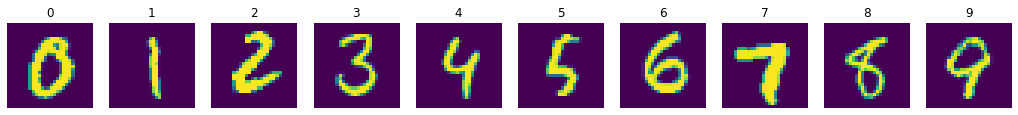

In [ ]:
# 看source data: 
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
example_files=[glob(f"mnistm_half/mnist_test/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

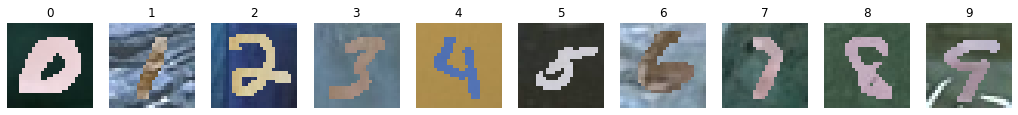

In [ ]:
# 看target data
example_files=[glob(f"mnistm_half/mnist_m_train/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

### 2.2 Data Loader設計
這邊我們三個loader
* source: 來源資料集，有MNIST圖片，也有對應的label
* target: 目標資料集，只有有MNIST-M 圖片，沒有label
* test: 測試資料集，有MNIST-M圖片，也有對應的label

Data Loader的要件:
* dataset: torchvision的VisionDataset，我們這邊使用ImageFolder作，只要把圖片依照分類放進資料夾就能依照資料夾名稱指定分類：
```
data_root
|--class 1
|   |--image 1
|   |--image 2
|   ...
|--class 2
|   |--image 3
...
```
* transform: augmentation function，這邊使用torchvision.transforms來做，也推薦[cv2 wrapaffine](https://theailearner.com/tag/cv2-warpaffine/)或者[albumentation](https://github.com/albumentations-team/albumentations)，因為這是Deep Learning CV的基本所以這邊不多贅述。

In [ ]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds

train_transform = tvt.Compose([
    tvt.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
])

# Source套用source的transform
source_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
# Target套用target的transform
target_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)
# Testing與Target那邊一樣資料，但會把label拿起來算準確度
test_dataset = tvds.ImageFolder('mnistm_half/mnist_m_test', transform=test_transform)

* dataloader: torch 本身的dataloader class，可以將上述loader的function做batching，以及安排shuffle和多線程等動作

In [ ]:
from torch.utils.data import DataLoader
# source跟target都使用小batch size
BS_TRAIN=32
BS_TEST=128
set_loader=lambda ldr: DataLoader(ldr, 
                                batch_size=BS_TRAIN,
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
source_dataloader,target_dataloader = [*map(set_loader,(source_dataset,target_dataset))]
# test dataset因為沒有gradient紀錄，GPU記憶體用量較小，所以可以開大一點batch size
test_dataloader = DataLoader(test_dataset,
                             batch_size=BS_TEST,
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True)

## 3.模型/演算法

### 3.1 Cell Classes
* convolution cell: convolution->normalization->activation->pooling組合
* dense cell: dense->normalization->activation組合

In [ ]:
import torch.nn as nn
# convolution cell: 
class conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, 1, 1),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self,x):
        return self.cell(x)
# dense cell: 
class dense(nn.Module):
    def __init__(self,ch_in=512,ch_out=512):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Linear(ch_in, ch_out),
            nn.BatchNorm1d(ch_out),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
    def forward(self,x):
        return self.cell(x)

### 3.2 Model Construction
這次模型包含:
* Feature Extractor: 針對圖片這邊使用數層CNN
* Label Predictor: 針對latent vector計算，所以用DNN就好
* Domain Classifier: 針對latent vector計算，所以用DNN就好

In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
# FeatureExtractor, 弄個4層cnn
class FeatureExtractor(nn.Module):
    def __init__(self,hidden_featrues=(64,128,256,512)):
        super().__init__()
        self.blocks = nn.Sequential(
            conv(3,hidden_featrues[0]),
            *[conv(ch1, ch2) for ch1,ch2 in zip(hidden_featrues[:-1],hidden_featrues[1:])],
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.blocks(x).squeeze()
# LabelPredictor, 弄個兩層dense
class LabelPredictor(nn.Module):
    def __init__(self,hidden_featrue=512):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(hidden_featrue, 10),
        )
    def forward(self, x):
        return self.blocks(x)
# DomainClassifier, 弄個4層dense
class DomainClassifier(nn.Module):
    def __init__(self,hidden_featrues=(512,256,128,64)):
        super().__init__()
        self.blocks = nn.Sequential(
            *[dense(ch1, ch2) for ch1,ch2 in zip(hidden_featrues[:-1],hidden_featrues[1:])],
            nn.Linear(hidden_featrues[-1], 1),
        )

    def forward(self, x):
        return self.blocks(x)

可大致對照回原本組成的三大塊

<img src=https://i.imgur.com/8XS2oyq.png  width="500" height="250">

## 4.模型訓練

### 4.1 Training Loss& Optimizer
可以當成一般分類問題來給訂相關loss、optimizer

**Loss function(criterion)**
* CCE: nn.CrossEntropyLoss給label predictor output用
* BCE: nn.BCEWithLogitsLoss給domain classifier output用

In [ ]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

**Optimizer**
* 這邊使用Adam來作optimization，且三個子模型要分開，因為每個訓練step會有兩個部分:
    * 訓練domain classifier
    * 訓練label predictor+feature extractor

In [ ]:
import torch.optim as optim
# 為了方便我們令一個class可以直接把dictionary key變成其attribute (可以直接用d.key)
class Dict:
    def __init__(self,d):
        self.__dict__=d
lr=0.001
optimizers=Dict({name:optim.Adam(m.parameters(),lr=lr) for name,m in 
                (("FE",feature_extractor),
                ("LP",label_predictor),
                ("DC",domain_classifier))
                })

若有調整model可以看一下summary確定axis數、每個axis維度是否如預期

In [ ]:
# from torchsummary import summary
# summary(feature_extractor, (3, 224, 224))
# summary(label_predictor, (3, 224, 224))
# summary(domain_classifier, (3, 224, 224))

### 4.2 Training Parameters& Callbacks

**Parameters**
- EPOCHS: 先設一個很大的數，當訓練不下去時也可以手動停止
- DISC_LOOPS: Discrimination可以比較多次一點，增加Discriminator強度

**Callbacks**
- Learning rate scheduling: ReduceLROnPlateau-模型訓練不下去時learning rate減少


In [ ]:
EPOCHS=20
DISC_LOOPS=2 # Domain Classifier重複訓練次數
# For scheduler
# schedulers=Dict({
#     k:optim.lr_scheduler.ReduceLROnPlateau(v, mode='min', factor=0.1, patience=5)
#     for k,v in optimizers.__dict__.items()
#     }) 

### 4.3Training Flow

In [ ]:
def train_epoch(source_dataloader, target_dataloader, lamb,with_da=True):
    running_D_loss, running_F_loss = 0.0, 0.0 # Domain Classifier的loss和Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    
       
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # 我們把source data和target data混在一起，讓normalization標準一致
        mixed_data = torch.cat([source_data, target_data], dim=0)
        # 設定source data的domain label為1, target的為0
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1

        # 訓練Domain Classifier
        feature_extractor.eval()
        domain_classifier.train()
        for _ in range(DISC_LOOPS):
            if _==DISC_LOOPS-1:
                feature = feature_extractor(mixed_data)
            else:
                with torch.no_grad():
                    feature = feature_extractor(mixed_data)
            # 不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
            domain_logits = domain_classifier(feature.detach())
            loss = domain_criterion(domain_logits, domain_label)
            running_D_loss+= loss.item()
            loss.backward()
            optimizers.DC.step()
            optimizers.DC.zero_grad()

        feature_extractor.train()
        domain_classifier.eval()
        # 訓練Feature Extractor和Label Predictor
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss為原本的class CE - lamb * domain loss
        # 將Discriminator。
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        loss=torch.clip(loss,min=1e-8)
        running_F_loss+= loss.item()
        loss.backward()
        
        optimizers.FE.step()
        # schedulers.FE.step(loss) # For scheduler
        optimizers.LP.step()
        # schedulers.LP.step(loss) # For scheduler

        optimizers.DC.zero_grad()        
        optimizers.FE.zero_grad()
        optimizers.LP.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
        #       D loss                F loss                     acc
    return running_D_loss/DISC_LOOPS/(i+1), running_F_loss / (i+1), total_hit / total_num

In [ ]:
# 訓練 epochs
try:
    for epoch in range(EPOCHS):
        # lambda可以開小一點，避免訓練Feature Extractor時loss變成負的
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)

        torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model.bin')

        print('epoch {:>3d}: DC loss: {:6.4f}, FE+LP l1oss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))
except KeyboardInterrupt:
    print("KeyboardInterrupt")

epoch   0: DC loss: 0.4866, FE+LP l1oss: 0.2456, acc 0.9029
epoch   1: DC loss: 0.5118, FE+LP l1oss: 0.0783, acc 0.9591
epoch   2: DC loss: 0.5241, FE+LP l1oss: 0.0613, acc 0.9674
epoch   3: DC loss: 0.5196, FE+LP l1oss: 0.0471, acc 0.9725
epoch   4: DC loss: 0.5226, FE+LP l1oss: 0.0423, acc 0.9736
epoch   5: DC loss: 0.5254, FE+LP l1oss: 0.0343, acc 0.9769
epoch   6: DC loss: 0.5266, FE+LP l1oss: 0.0320, acc 0.9777
epoch   7: DC loss: 0.5265, FE+LP l1oss: 0.0273, acc 0.9803
epoch   8: DC loss: 0.5199, FE+LP l1oss: 0.0248, acc 0.9820
epoch   9: DC loss: 0.5240, FE+LP l1oss: 0.0253, acc 0.9809
epoch  10: DC loss: 0.5219, FE+LP l1oss: 0.0202, acc 0.9841
epoch  11: DC loss: 0.5240, FE+LP l1oss: 0.0201, acc 0.9835
epoch  12: DC loss: 0.5244, FE+LP l1oss: 0.0183, acc 0.9849
epoch  13: DC loss: 0.5193, FE+LP l1oss: 0.0148, acc 0.9860
epoch  14: DC loss: 0.5267, FE+LP l1oss: 0.0157, acc 0.9860
epoch  15: DC loss: 0.5259, FE+LP l1oss: 0.0159, acc 0.9860
epoch  16: DC loss: 0.5271, FE+LP l1oss:

## 5.預測&評估
把 test_dataset拿出來預測結果，並看在target domain這些沒見過的資料是否能夠預測準確

In [ ]:
result = []
total_test_hit, total_test_num = 0.0, 0.0
label_predictor.eval()
feature_extractor.eval()
with torch.no_grad():
    for i, d in enumerate(test_dataloader):
        test_data,test_label=[*map(lambda x: x.cuda(),d)]

        class_logits = label_predictor(feature_extractor(test_data))

        pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(pred)
        total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
        total_test_num += test_data.shape[0]

print("test acc:",total_test_hit / total_test_num)

test acc: 0.6932


## 6.練習

1. 請試著調整參數看對結果的影響
    * DISC_LOOPS: Domain Classifier的優勢性(一般GAN的訓練會大於1，讓Discriminator較早訓練得快，因為Discriminator較不容易訓練)
    * Lamb: Domain classifier回傳反向的gradient影響的比例
    * Augmentation: 可新增更多augmentation增加模型穩定度，不過會更難訓練
    * Learning rate scheduling: 加入Reduce Learning rate on plateau讓訓練更為fitting
    * 修改Feature Extractor，可改用Resnet等架構
2. 請試著反過來將MNIST-M作為source、MNIST作為target及testing set，看看訓練效果有沒有改變
* e.g.
```
source_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)
target_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
test_dataset = tvds.ImageFolder('mnistm_half/mnist_test', transform=test_transform)
```

3. 請將Domain Adaptation部分拿掉，看看測試集的performance改變
* e.g.
```
# # 訓練Domain Classifier
# domain_classifier.train()
# for _ in range(DISC_LOOPS):
with torch.no_grad():
    feature = feature_extractor(mixed_data)
#     loss = domain_criterion(domain_logits, domain_label)
#     running_D_loss+= loss.item()
#     loss.backward()
#     optimizers.DC.step()
#     # schedulers.DC.step(loss) # For scheduler
#     optimizers.DC.zero_grad()
...
# 訓練Feature Extractor和Label Predictor
# domain_classifier.eval()
# class_logits = label_predictor(feature[:source_data.shape[0]])
# domain_logits = domain_classifier(feature)
# # loss為原本的class CE - lamb * domain loss
# # 將Discriminator。
loss = class_criterion(class_logits, source_label)
running_F_loss+= loss.item()
loss.backward()
```

## 7. 參考資料
* [Wang, M., & Deng, W. (2018). Deep visual domain adaptation: A survey. Neurocomputing, 312, 135-153.](https://arxiv.org/abs/1802.03601)
    - Domain Adaptation的 Survey Paper
    - 包含Discrepancy-based、Adversarial-based、Reconstruction-based三種流派的介紹
    
* [Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., ... & Lempitsky, V. (2016). Domain-adversarial training of neural networks. The journal of machine learning research, 17(1), 2096-2030.](https://arxiv.org/pdf/1505.07818.pdf)
    - Domain Adversarial Training of Nerural Networks原文

* [Paper with code 排名](https://paperswithcode.com/task/domain-adaptation)

* [推薦論文集匯](https://github.com/zhaoxin94/awesome-domain-adaptation#object-detection)